In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from ipywidgets import interact
from helper_functions import zscore_normalize_features, run_gradient_descent_poly, plot_sigmoid, sigmoid, draw_threshold, plot_probability

<h1 style="text-align:center">Regression Problems in Machine Learning</h1>
<h3 style="text-align:center">The Math behind</h3>

>Note: The code will be written in vectorization form using NumPy. My approach of explaining and solving the problems will be purely mathematical, without any ML libraries (sklearn or similar)

In this doc. im going to present how to solve regression problems and how to create a predictive model for this type of problems like:
 - Linear Regression
 - Polynomial Regression
 - Logistic Regression (Classification) 

Also im going to explain the most fundamentals terms like:
 - Cost Function
 - Gradient Descent
 - Feature Scaling

#### 1. Linear Regression - finding the best fit line for the artificial data using the formula for a straight line as $w$ and $b$ are the model parameters. </br>
Different values of $w$ and $b$ result in different straight line on the plot.

 - The data will be distance in km`s and the coresponding time for delivery in minutes. The goal of the model is to predict for new distance point, how much time it will take for a delivery to arrive.
 - Model function is:

$$ f_{w, b}(x^{(i)}) = w x^{(i)} + b $$

In [ ]:
# generating artificial data with noise, 21 examples
np.random.seed(42)
distance = np.arange(1, 22)
delivery_time = 12 + distance * 5 + np.random.normal(0, 9, size=21)

x_train = distance
y_train = delivery_time

# 1-D array
print(f"Training data shape: {x_train.shape}")
print(f"Number of training examples is: {x_train.shape[0]}")
print(f"Target values shape: {y_train.shape}")
print(f"Number of target examples is: {y_train.shape[0]}")

Training data shape: (21,)
Number of training examples is: 21
Target values shape: (21,)
Number of target examples is: 21


 - Plotting the data

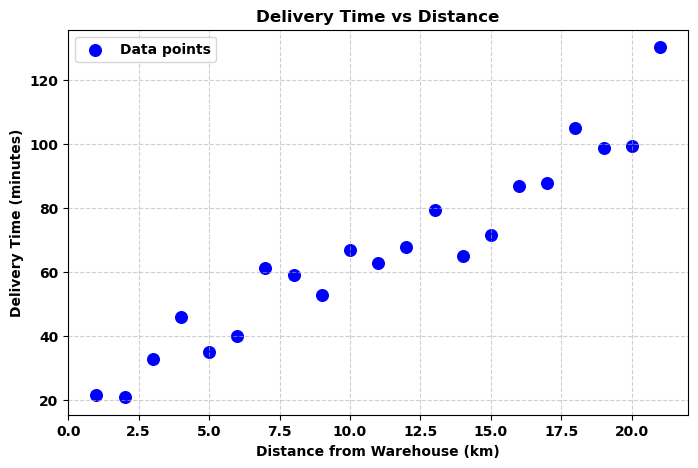

In [ ]:
# plot the data
plt.figure(figsize=(8, 5))
plt.scatter(distance, np.round(delivery_time, 2), color='blue', s=70, label='Data points')
plt.title('Delivery Time vs Distance')
plt.xlabel('Distance from Warehouse (km)')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

 - Lets set some random values for $w$ and $b$ and see how well the model will describe the data.

In [ ]:
# randomly chosen values for the model params
w = 10
b = 30

In [ ]:
def compute_model_output(x, w, b):
    """
    Computes the prediction of a linear model
    Args:
      x (ndarray (m,)): Data, m examples 
      w,b (scalar)    : model parameters  
    Returns
      f_wb (ndarray (m,)): model prediction
    """
    f_wb = w * x + b      
  
    return f_wb

In [ ]:
# model predictions with w = 10 and b = 30
y_pred = compute_model_output(x_train, w, b)
y_pred

array([ 40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140, 150, 160,
       170, 180, 190, 200, 210, 220, 230, 240])

- Now plotting the predicted values of the model and check how accurate, it learned the training data.

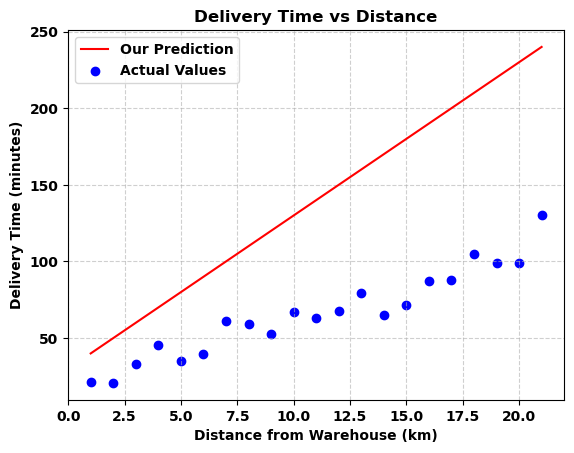

In [ ]:
# Plot our model prediction
plt.plot(x_train, y_pred, c='r',label='Our Prediction')

# Plot the data points
plt.scatter(x_train, y_train, c='b',label='Actual Values')


plt.title('Delivery Time vs Distance')
plt.xlabel('Distance from Warehouse (km)')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

 - Pretty bad predictions with model params $w = 10$ and $b = 30$. The line is way to off from the true data points. </br>
 In that case i need something that tells me how good or how bad my model is performing, and that something will be a Cost function.

#### 2. Cost function for Linear Regression.
 - Cost function is a measure how well our model is predicting the target delivery time for the given distance.

- The cost function im going to use is called Mean Squared Error - MSE. The MSE func. is smooth and differentiable function so it works well with calculus-based optimization like gradient descent, which im going to use.
- Also for linear regression, the MSE surface is convex so there is only one global minimum which helps a lot when optimizing the model params.
- It has a closed-form solutions allows us to derive explicit formulas for the best parameters (normal equations).
- And it’s easy to interpret

The equation for Cost is:
$$ J(w,b) = \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2 $$

where 
  $$f_{w,b}(x^{(i)}) = wx^{(i)} + b $$
  
- $f_{w,b}(x^{(i)})$ is our prediction for example $i$ using parameters $w,b$.  
- $(f_{w,b}(x^{(i)}) -y^{(i)})^2$ is the squared difference between the target value and the prediction.   
- These differences are summed over all the $m$ examples and divided by $2m$ to produce the cost, $J(w,b)$.  

In [ ]:
def compute_cost(x, y, w, b): 
    """
    Computes the cost function for linear regression.
    
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    
    Returns
        total_cost (float): The cost of using w,b as the parameters for linear regression
               to fit the data points in x and y
    """
    # number of training examples
    m = x.shape[0]
    
    total_cost = np.sum(((w * x + b) - y) ** 2)
    avg_cost = total_cost / (2 * m)

    return avg_cost

In [ ]:
mse = compute_cost(x_train, y_train, w, b)
print(f"Current Cost: {mse:.2f}")

Current Cost: 3330.01


- The goal is to minimize MSE function by adjusting model params $w$ and $b$
- One way of doing it is using Gradient Descent

#### 3. Gradient Descent

- Gradient descent is an optimization algorithm that uses the first derivative of the MSE (or any loss function) with respect to the model parameters to find the minimum.
- The algorithm repeats until convergence, where the best values for $w$ and $b$ are found when the cost is at its lowest point.
- we update $w$ and $b$ when from their initial values subtract hyperparameter called alpha -> $\alpha$ multiplied by the 1st derivative of the MSE function, with respect to $w$ and $b$


$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline
\;  w &= w -  \alpha \frac{\partial J(w,b)}{\partial w} \; \newline 
 b &= b -  \alpha \frac{\partial J(w,b)}{\partial b}  \newline \rbrace
\end{align*}$$
parameters $w$, $b$ are updated simultaneously.  
The gradient is defined as:
$$
\begin{align*}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \\
\end{align*}$$

In [ ]:
def compute_derivative(x, y, w, b): 
    """
    Computes the gradient for linear regression 
    Args:
      x (ndarray (m,)): Data, m examples 
      y (ndarray (m,)): target values
      w,b (scalar)    : model parameters  
    Returns
      dj_dw (scalar): The gradient of the cost w.r.t. the parameters w
      dj_db (scalar): The gradient of the cost w.r.t. the parameter b     
     """
    
    # Number of training examples
    m = x.shape[0]  
    y_predicted =   w * x + b
    dj_dw = np.sum((y_predicted - y) * x) / m
    dj_db = np.sum((y_predicted - y)) / m
        
    return dj_dw, dj_db

In [ ]:
dj_dw, dj_db = compute_derivative(x_train, y_train, w, b)
dj_dw, dj_db

(np.float64(1016.9353207938607), np.float64(73.84013819710643))

In [ ]:
def gradient_descent(x, y, w, b, alpha, iterations, cost_function, derivative): 
    """
    Performs gradient descent to fit w,b. Updates w,b by taking 
    iterations gradient steps with learning rate alpha
    
    Args:
      x (ndarray (m,))  : Data, m examples 
      y (ndarray (m,))  : target values
      w,b (scalar): initial values of model parameters  
      alpha (float):     Learning rate
      iterations (int):   number of iterations to run gradient descent
      cost_function:     function to call to produce cost
      derivative: function to call to produce gradient
      
    Returns:
      w (scalar): Updated value of parameter after running gradient descent
      b (scalar): Updated value of parameter after running gradient descent
      J_history (List): History of cost values
      """
    
    # An array to store cost J
    J_history = []
    
    w_new = w
    b_new = b
    
    for i in range(iterations):
        # Calculate the gradient
        dj_dw, dj_db = derivative(x, y, w_new , b_new)     

        # Update Parameters
        w_new -= alpha * dj_dw  
        b_new -= alpha * dj_db                                                      

        # Save cost J at each iteration
        J_history.append(cost_function(x, y, w_new , b_new))

        # Print cost every at intervals 10 times
        if i % np.ceil(iterations / 10) == 0:
            print(f"Iteration {i:4}: Cost {J_history[-1]:0.2e} ",
                  f"dj_dw: {dj_dw: 0.3e}, dj_db: {dj_db: 0.3e}  ",
                  f"w: {w_new: 0.3e}, b:{b_new: 0.5e}")
 
    return w_new, b_new

In [ ]:
# test with 3000 itereations
iterations = 4000
alpha = 1.0e-2
w_best, b_best = gradient_descent(x_train, y_train, w, b, alpha, iterations, compute_cost, compute_derivative)
print(f"(w,b) found by gradient descent: ({w_best:.4f},{b_best:8.4f})")

Iteration    0: Cost 1.17e+03  dj_dw:  1.017e+03, dj_db:  7.384e+01   w: -1.694e-01, b: 2.92616e+01
Iteration  400: Cost 3.51e+01  dj_dw: -7.670e-02, dj_db:  1.098e+00   w:  4.087e+00, b: 2.23003e+01
Iteration  800: Cost 3.29e+01  dj_dw: -3.036e-02, dj_db:  4.345e-01   w:  4.287e+00, b: 1.94412e+01
Iteration 1200: Cost 3.25e+01  dj_dw: -1.202e-02, dj_db:  1.720e-01   w:  4.366e+00, b: 1.83094e+01
Iteration 1600: Cost 3.25e+01  dj_dw: -4.757e-03, dj_db:  6.808e-02   w:  4.397e+00, b: 1.78615e+01
Iteration 2000: Cost 3.25e+01  dj_dw: -1.883e-03, dj_db:  2.695e-02   w:  4.409e+00, b: 1.76842e+01
Iteration 2400: Cost 3.25e+01  dj_dw: -7.452e-04, dj_db:  1.067e-02   w:  4.414e+00, b: 1.76140e+01
Iteration 2800: Cost 3.25e+01  dj_dw: -2.950e-04, dj_db:  4.222e-03   w:  4.416e+00, b: 1.75862e+01
Iteration 3200: Cost 3.25e+01  dj_dw: -1.168e-04, dj_db:  1.671e-03   w:  4.417e+00, b: 1.75752e+01
Iteration 3600: Cost 3.25e+01  dj_dw: -4.621e-05, dj_db:  6.614e-04   w:  4.417e+00, b: 1.75709e+01


In [ ]:
y_pred_updated = compute_model_output(x_train, w_best, b_best)

# comparing the new predicted values vs old prediction with not updated model params
print(f"Old predictions, w = {w}, b = {b} \n {y_pred} \n")
print(f"New predictions, updated: w = {w_best:.4f}, b = {b_best:.4f} \n {y_pred_updated} \n")
print(f"Target values: \n {y_train}")

Old predictions, w = 10, b = 30 
 [ 40  50  60  70  80  90 100 110 120 130 140 150 160 170 180 190 200 210
 220 230 240] 

New predictions, updated: w = 4.4174, b = 17.5691 
 [ 21.98649603  26.40385879  30.82122155  35.23858431  39.65594707
  44.07330982  48.49067258  52.90803534  57.3253981   61.74276086
  66.16012362  70.57748637  74.99484913  79.41221189  83.82957465
  88.24693741  92.66430017  97.08166292 101.49902568 105.91638844
 110.3337512 ] 

Target values: 
 [ 21.47042738  20.75562129  32.82919684  45.70726871  34.89261963
  39.89276739  61.21291534  58.90691256  52.77473053  66.88304039
  62.82924076  67.80843222  79.17766044  64.7804778   71.47573951
  86.93941224  87.88451992 104.82822599  98.82778332  99.28926669
 130.19083892]


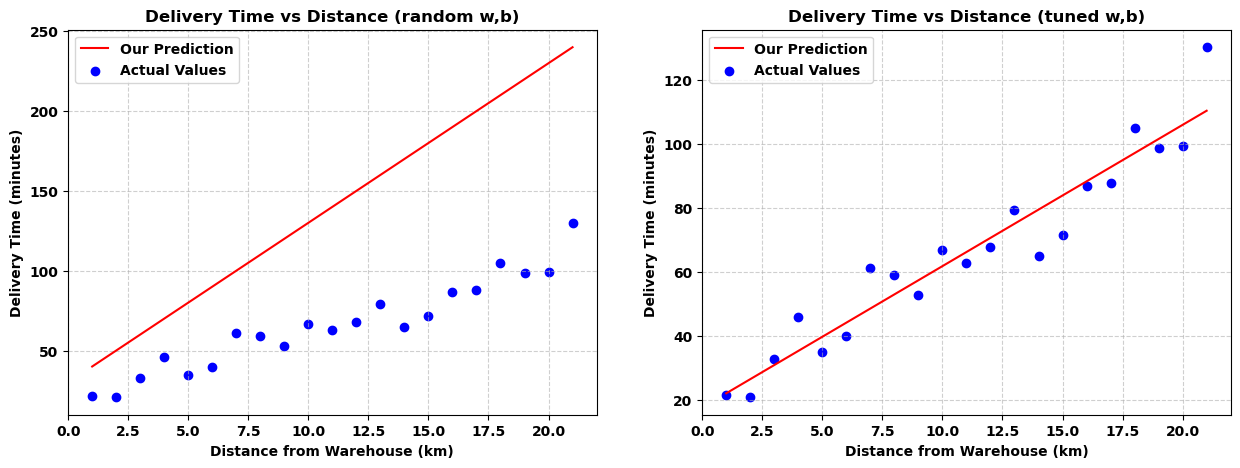

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
# Plot our model prediction
plt.plot(x_train, y_pred, c='r',label='Our Prediction')

# Plot the data points
plt.scatter(x_train, y_train, c='b',label='Actual Values')


plt.title('Delivery Time vs Distance (random w,b)')
plt.xlabel('Distance from Warehouse (km)')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.subplot(1, 2, 2)
# Plot our model prediction
plt.plot(x_train, y_pred_updated, c='r',label='Our Prediction')

# Plot the data points
plt.scatter(x_train, y_train, c='b',label='Actual Values')


plt.title('Delivery Time vs Distance (tuned w,b)')
plt.xlabel('Distance from Warehouse (km)')
plt.ylabel('Delivery Time (minutes)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

In [ ]:
mse = compute_cost(x_train, y_train, w, b)
mse_updated = compute_cost(x_train, y_train, w_best, b_best)

print(f"Old MSE: w = {w}, b = {b} \n Cost: {mse} \n")
print(f"New MSE: w = {w_best:.4f}, b = {b_best:.4f} \n Cost: {mse_updated}")

Old MSE: w = 10, b = 30 
 Cost: 3330.012438993228 

New MSE: w = 4.4174, b = 17.5691 
 Cost: 32.47190718647745


 - Another way to find the best $w$ and $b$ directly without convergence algorithm for Linear Regression is through closed form solution (normal equations / Ordinary Least Square) using the following formula:

1-st take the partial derivative of MSE with respent to $w$ and $b$:
$$ J(w,b)= \frac{1}{2m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})^2 $$

$$
\begin{align*}
\frac{\partial J(w,b)}{\partial w}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} \\
  \frac{\partial J(w,b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) \\
\end{align*}$$

Set both equations to be equal to 0 and multiply by $m$:
$$
\begin{align*}
\sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)})x^{(i)} = 0 \\
\sum\limits_{i = 0}^{m-1} (f_{w,b}(x^{(i)}) - y^{(i)}) = 0 
\end{align*}$$

Expand the equations:

Equation 2:
$$
\begin{align*}
\sum\limits_{i = 0}^{m-1} (wx^{(i)} + b - y^{(i)}) = 0 \\
w\sum\limits_{i = 0}^{m-1}x^{(i)} + mb - \sum\limits_{i = 0}^{m-1}y^{(i)} = 0
\end{align*}$$

Equation 1:
$$
\begin{align*}
\sum\limits_{i = 0}^{m-1} (wx^{(i)} + b - y^{(i)})x^{(i)} = 0 \\
w\sum\limits_{i = 0}^{m-1}(x^{(i)})^2 + b\sum\limits_{i = 0}^{m-1}x^{(i)} - \sum\limits_{i = 0}^{m-1}y^{(i)}x^{(i)} = 0
\end{align*}$$

Solving system of 2 equation:
$$
\left\{ \begin{array}{rcl} \\
w\sum\limits_{i = 0}^{m-1}x^{(i)} + mb - \sum\limits_{i = 0}^{m-1}y^{(i)} = 0 \\
w\sum\limits_{i = 0}^{m-1}(x^{(i)})^2 + b\sum\limits_{i = 0}^{m-1}x^{(i)} - \sum\limits_{i = 0}^{m-1}y^{(i)}x^{(i)} = 0
\end{array}\right.
$$

After system solving, the final formulas for $w$ and $b$ looks like this:
$$ w = \frac{\sum\limits_{i = 0}^{m-1}y^{(i)}x^{(i)} - \frac{1}{m} \sum\limits_{i = 0}^{m-1}x^{(i)} \sum\limits_{i = 0}^{m-1}y^{(i)}}{\sum\limits_{i = 0}^{m-1}(x^{(i)})^2 - \frac{1}{m}(\sum\limits_{i = 0}^{m-1}x^{(i)})^2} = \frac{\sum\limits_{i = 0}^{m-1}(x^{(i)} - \overline{x})(y^{(i)} - \overline{y})}{\sum\limits_{i = 0}^{m-1}(x^{(i)} - \overline{x})^2} $$
$$ b = \frac{1}{m}\sum\limits_{i = 0}^{m-1}y^{(i)} - w\frac{1}{m}\sum\limits_{i = 0}^{m-1}x^{(i)} = \overline{y} - w\overline{x} $$


- This way of solution works only in Simple Linear Regressin!

In [ ]:
w_ols = np.sum((x_train - np.mean(x_train)) * (y_train - np.mean(y_train))) / np.sum((x_train - np.mean(x_train)) ** 2)
b_ols = np.mean(y_train) - (w_ols * np.mean(x_train))
round(w_ols, 4), round(b_ols, 4)

# getting the same coeficents with OLS solution as the gradient descent update
print(f"OLS w = {w_ols:.2f} \nOLS b = {b_ols:.2f} \n\nGD w = {w_best:.2f} \nGD b = {b_best:.2f}")

OLS w = 4.42 
OLS b = 17.57 

GD w = 4.42 
GD b = 17.57


- On the plot below we can play with different values for $w$ and $b$ and see how the cost changes, also the fitting line. If we choose for $w = 4.42$ and $b = 17.57$ we get the best fit line.

>Note: Don`t mind the plotting code.

In [ ]:
w_range = np.linspace(0, 11, 300)

def plot_interactive(w, b):
    mse_values = [compute_cost(x_train, y_train, wi, b) for wi in w_range]
    min_idx = np.argmin(mse_values)
    min_w = w_range[min_idx]
    min_mse = mse_values[min_idx]
    current_mse = compute_cost(x_train, y_train, w, b)
    
    fig = make_subplots(
        rows=1, cols=2, subplot_titles=("Data and Linear Model", "Cost Function MSE"),
        horizontal_spacing=0.15
    )
    
    fig.add_trace(go.Scatter(
        x=x_train, y=y_train, mode='markers', name='Data', marker=dict(color='blue')), row=1, col=1)
    
    fig.add_trace(go.Scatter(
        x=x_train, y=w*x_train + b, mode='lines', name=f'Current: y={w:.2f}x+{b:.2f}', line=dict(color='red')), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=x_train, y=min_w*x_train + b, mode='lines', name=f'Best fit: y={min_w:.2f}x+{b:.2f}', 
        line=dict(color='green', dash='dash')), row=1, col=1)

    fig.add_shape(type="line", x0=0, x1=10, y0=0, y1=0, line=dict(color="black", width=1), row=1, col=1)
    fig.add_shape(type="line", x0=0, x1=0, y0=min(y_train)-5, y1=max(y_train)+5, line=dict(color="black", width=1), row=1, col=1)
    

    fig.add_trace(go.Scatter(
        x=w_range, y=mse_values, name='MSE(w)', line=dict(color='blue')), row=1, col=2)

    fig.add_trace(go.Scatter(
        x=[w], y=[current_mse], mode='markers', marker=dict(color='red', size=10), name='Current w'), row=1, col=2)
    fig.add_vline(x=w, line=dict(color='red', dash='dash'), row=1, col=2)

    fig.add_trace(go.Scatter(
        x=[min_w], y=[min_mse], mode='markers+text', marker=dict(color='green', size=13),
        text=[f"min at w={min_w:.2f}, MSE={min_mse:.2f}"], textposition="bottom right",
        name='Minimum'), row=1, col=2)
    fig.add_vline(x=min_w, line=dict(color='green', dash='dot'), row=1, col=2)

    fig.add_shape(type="line", x0=min(w_range), x1=max(w_range), y0=0, y1=0, line=dict(color="black", width=1), row=1, col=2)
    fig.add_shape(type="line", x0=0, x1=0, y0=0, y1=max(mse_values)+10, line=dict(color="black", width=1), row=1, col=2)
    

    fig.update_xaxes(title_text="x", row=1, col=1)
    fig.update_yaxes(title_text="y", row=1, col=1)
    fig.update_xaxes(title_text="w", row=1, col=2)
    fig.update_yaxes(title_text="MSE", row=1, col=2)
    fig.update_layout(
         height=480, width=1200, showlegend=True
    )
    fig.show()


w_slider = widgets.FloatSlider(value=1.0, min=-2.0, max=10.0, step=0.01, description="w")
b_slider = widgets.FloatSlider(value=1.0, min=-1.0, max=30.0, step=0.01, description="b")

interact(plot_interactive, w=w_slider, b=b_slider);


#### 4. Multivariable Linear Regression

- basically we have the same step, instead now, the features are more than one and the formula looks like this:


$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_0x_0 + w_1x_1 +... + w_{n-1}x_{n-1} + b \tag{1} $$

- the data can be represented as matrix:
$$\mathbf{X} = 
\begin{pmatrix}
 x^{(0)}_0 & x^{(0)}_1 & \cdots & x^{(0)}_{n-1} \\ 
 x^{(1)}_0 & x^{(1)}_1 & \cdots & x^{(1)}_{n-1} \\
 \cdots \\
 x^{(m-1)}_0 & x^{(m-1)}_1 & \cdots & x^{(m-1)}_{n-1} 
\end{pmatrix}
$$

- and the $w$ parameter is presented as vector with with coeficents for every $x$ feature in the matrix $X$: 
$$\mathbf{w} = \begin{pmatrix}
w_0 \\ 
w_1 \\
\cdots\\
w_{n-1}
\end{pmatrix}
$$

- all the steps for finding the best parameters with gradient descent are the same as Simple Linear Regression, except the close form solution, which looks like this:
$$ w = (X^TX)^{-1}X^Ty $$

#### 5. Polynomial Regression

- generating artifitial data needed for the example:

In [ ]:
x_train = np.arange(0,20,1)
y_train = np.cos(x_train / 2)

# transforming to 2D array
x_train_example = x_train.reshape(-1, 1)
x_train_example.shape


(20, 1)

- for this example $w=0.2$ and $b=-0.7$

In [ ]:
w = 0.2
b = -0.7

- the model prediction using the formula for a line wont help, as shown on the plot below.

In [ ]:
y_pred = w * x_train + b

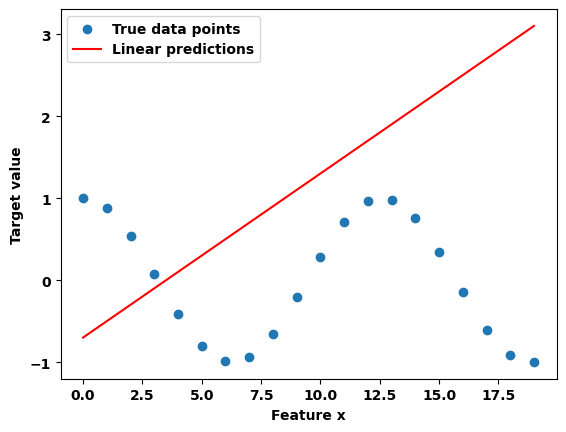

In [ ]:
plt.scatter(x_train_example , y_train, label='True data points')
plt.plot(x_train_example, y_pred, c='r', label='Linear predictions')
plt.xlabel("Feature x")
plt.ylabel("Target value")
plt.legend()
plt.show()

- i`m going to use polynomial features. Polynomial features are a way to expand the input features into higher-order combinations, enabling linear models (like linear regression) to fit non-linear relationships.

- let`s create a polynomial features of $degree = 13$

- the new formula for predictions becomes like this:

$$d=13 $$
$$f_{w, b}(x_{j}^{a}) = w_1x_1^{a_1} +  w_2x_2^{a_1} + w_3x_1^{a_1}x_2^{a_1} + w_4x_1^{a_2} + w_5x_2^{a_2} + w_6x_1^{a_1}x_2^{a_2} +...+ w_nx_j^{a_n}$$


$$where: a_1 + a_2 +.....+ a_n \leq d $$


In [ ]:
# expanding the training data with features to degree of 13
X = np.c_[x_train, x_train**2, x_train**3, x_train**4, x_train**5, x_train**6, x_train**7, x_train**8, x_train**9, x_train**10, x_train**11, x_train**12, x_train**13]

In [ ]:
X.shape

(20, 13)

- using the same formula for computing the gradient as MSE in Linear Regression, except that, now the demensions are different.
- starting params for $w$ = vector of zeros, and $b=0$

>Note: To avoid repeating and stacking similar code the function implementations for Polynomial Regression can be found in helper_functions.ipynb file.

- to prevent big number calculations (integer overflow) i need to scale the features with mean = 0 and standard deviation = 1.
- i`m using z-score normalization for scaling:
$$X_{norm[i, j]} = \frac{X_{norm[i, j]} - \mu_{j}}{\sigma_{j}} $$

In [ ]:
X = zscore_normalize_features(X)

- below are the best values for $w$ and $b$ found by gradient descent, also the prediction curve for the given data points.

Iteration         0, Cost: 2.20188e-01
Iteration     10000, Cost: 2.50319e-02
Iteration     20000, Cost: 2.29448e-02
Iteration     30000, Cost: 2.16085e-02
Iteration     40000, Cost: 2.06484e-02
Iteration     50000, Cost: 1.98819e-02
Iteration     60000, Cost: 1.92198e-02
Iteration     70000, Cost: 1.86182e-02
Iteration     80000, Cost: 1.80553e-02
Iteration     90000, Cost: 1.75202e-02

w,b found by gradient descent: 

w: [-3.70261975  3.54511497  6.45473929  0.34803821 -4.2053263  -4.99061744
 -3.20700353 -0.54386497  1.73399952  2.89702512  2.63080534  0.8899767
 -2.21717668], 
b: -0.0073


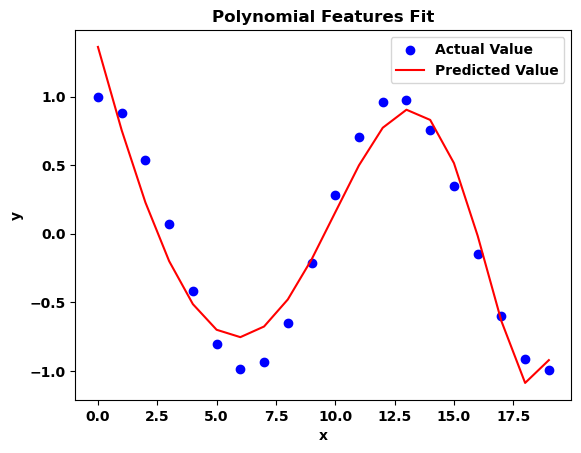

In [ ]:
model_w,model_b = run_gradient_descent_poly(X, y_train, 100000, 0.1)

y_pred = X @ model_w + model_b

plt.scatter(x_train, y_train, c='blue', label="Actual Value"); plt.title('Polynomial Features Fit')
plt.plot(x_train, y_pred, c="red", label="Predicted Value"); 
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

#### 6. Classification / Logistic Regression
- examples of classification problems are things like, identifying email as spam or not, image recognition of dog or cat, medical diagnosis has disease or not and many more, these are examples of binary classification where there are two possible outcomes. Outcomes can be described as `positive/negative`, `yes or no`, `true or false` or `1/0`

- we can start by using the linear regression equation: $f_{w,b}(x^{(i)}) = w \cdot x^{(i)} + b $, to predict $y$. But for the cassification predictions we need the output to be between 0 and 1. This can be accomplished by using a "sigmoid function" (or also called "logistic function") which maps all input values to values between 0 and 1.

- formula for sigmoid function is: 
$$ g(z) = \frac{1}{1+e^{-z}}  $$

- a logistic regression model applies the sigmoid to the linear regression equation as shown below:
$$ f_{w,b}(x^{(i)}) = g(w \cdot x^{(i)} + b) $$

- here is a quick visualization of the sigmoid function and how it works.

In [ ]:
plot_sigmoid()

- lets generate some training data with two features and the coresponding true values ($y$) for it. 

In [ ]:
X = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y = np.array([0, 0, 0, 1, 1, 1]).reshape(-1,1) 

- plotting the data.

In [ ]:
def plot_data(X, y, ax):
    """ plots logistic data with two axis """
    # Find Indices of Positive and Negative Examples
    pos = y == 1
    neg = y == 0
    pos = pos.reshape(-1,)
    neg = neg.reshape(-1,)

    ax.scatter(X[pos, 0], X[pos, 1], marker='x', s=80, c = 'red', label="y=1")
    ax.scatter(X[neg, 0], X[neg, 1], marker='o', s=80, label="y=0", facecolors='none', edgecolors='#0096ff', lw=3)
    ax.legend(loc='best')

    ax.figure.canvas.toolbar_visible = False
    ax.figure.canvas.header_visible = False
    ax.figure.canvas.footer_visible = False

- red crosses are Class 1 where $y=1$ and blue circles Class 2 where $y=0$

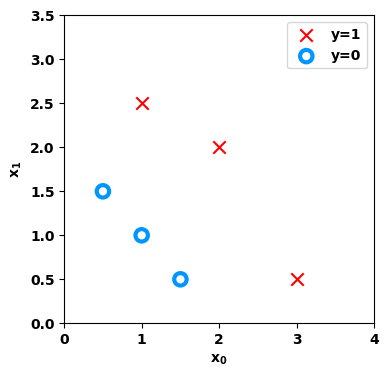

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X, y, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$')
ax.set_xlabel('$x_0$')
plt.show()

* Suppose we like to train a logistic regression model on this data which has the form   

  $f(x) = g(w_0x_0+w_1x_1 + b)$
  
  where $g(z) = \frac{1}{1+e^{-z}}$, which is the sigmoid function

- To understand what this trained model is predicting, let`s try to plot its decision boundary.

* We interpret the output of the model ($f_{\mathbf{w},b}(x)$) as the probability that $y=1$ given $\mathbf{x}$ and parameterized by $\mathbf{w}$ and $b$.
* Therefore, to get a final prediction ($y=0$ or $y=1$) from the logistic regression model, we can use the following heuristic -

  if $f_{\mathbf{w},b}(x) >= 0.5$, predict $y=1$
  
  if $f_{\mathbf{w},b}(x) < 0.5$, predict $y=0$
  
  
* Let's plot the sigmoid function to see where $g(z) >= 0.5$

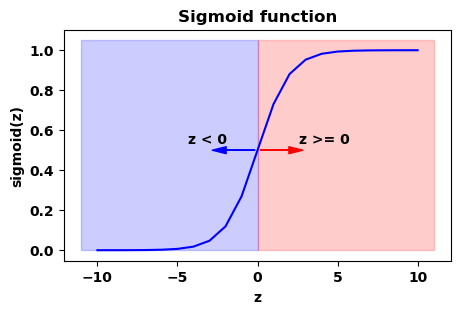

In [ ]:
z = np.arange(-10,11)

fig,ax = plt.subplots(1,1,figsize=(5,3))
# Plot z vs sigmoid(z)
ax.plot(z, sigmoid(z), c="b")

ax.set_title("Sigmoid function")
ax.set_ylabel('sigmoid(z)')
ax.set_xlabel('z')
draw_threshold(ax,0)

* As we can see, $g(z) >= 0.5$ for $z >=0$

* For a logistic regression model, $z = \mathbf{w} \cdot \mathbf{x} + b$. Therefore,

  if $\mathbf{w} \cdot \mathbf{x} + b >= 0$, the model predicts $y=1$
  
  if $\mathbf{w} \cdot \mathbf{x} + b < 0$, the model predicts $y=0$
  
  
  
### Plotting decision boundary

* Let's say that we trained the model and get the parameters as $b = -3, w_0 = 1, w_1 = 1$. That is,

  $f(x) = g(x_0+x_1-3)$

* Our logistic regression model has the form

  $f(\mathbf{x}) = g(-3 + x_0+x_1)$


* so this model predicts $y=1$ if $-3 + x_0+x_1 >= 0$

Let's see what this looks like graphically. I'll start by plotting $-3 + x_0+x_1 = 0$, which is equivalent to $x_1 = 3 - x_0$.


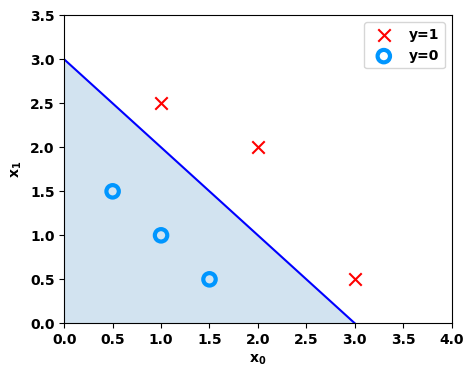

In [ ]:
x0 = np.arange(0, 6)

x1 = 3 - x0
fig,ax = plt.subplots(1, 1, figsize=(5, 4))
# Plot the decision boundary
ax.plot(x0, x1, c="b")
ax.axis([0, 4, 0, 3.5])
ax.fill_between(x0, x1, alpha=0.2)

# Plot the original data
plot_data(X, y, ax)
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')
plt.show()

* In the plot above, the blue line represents the line $x_0 + x_1 - 3 = 0$ and it should intersect the $x_1$ axis at 3 (if we set $x_1$ = 3, $x_0$ = 0) and the $x_0$ axis at 3 (if we set $x_1$ = 0, $x_0$ = 3). 

* this is a linear equation of two variables, it defines a line in 2D space.

* The shaded region represents $-3 + x_0+x_1 < 0$. The region above the line is $-3 + x_0+x_1 > 0$.


* Any point in the shaded region is classified as $y=0$.  Any point on or above the line is classified as $y=1$. This line is known as the "decision boundary".

By using higher order polynomial terms like ($f(x) = g( x_0^2 + x_1 -1)$, we can come up with more complex non-linear boundaries.

#### 7. Cost Function for Logistic Regression

Logistic Regression uses a loss function more suited to the task of categorization where the target is 0 or 1 rather than any number. 

This is defined: 
* $loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)})$ is the cost for a single data point, which is:

\begin{equation*}
  loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = \begin{cases}
    - \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) & \text{if $y^{(i)}=1$}\\
    - \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) & \text{if $y^{(i)}=0$}
  \end{cases}
\end{equation*}


*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value.

*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)}) = g(\mathbf{w} \cdot\mathbf{x}^{(i)}+b)$ where function $g$ is the sigmoid function.

The defining feature of this loss function is the fact that it uses two separate curves. One for the case when the target is zero or ($y=0$) and another for when the target is one ($y=1$). Combined, these curves provide the behavior useful for a loss function, namely, being zero when the prediction matches the target and rapidly increasing in value as the prediction differs from the target.

- Let`s start with, why $-log()$? 
 - -log() is the inverse function of log(). Both functions intersect at x-axis at $x=1$ (as shown on the plot) and since the sigmoid function can have outputs between 0 and 1, we just need that part of the inverse $log()$ function where it crosses $x=1$ and so the cost will be a positive number.

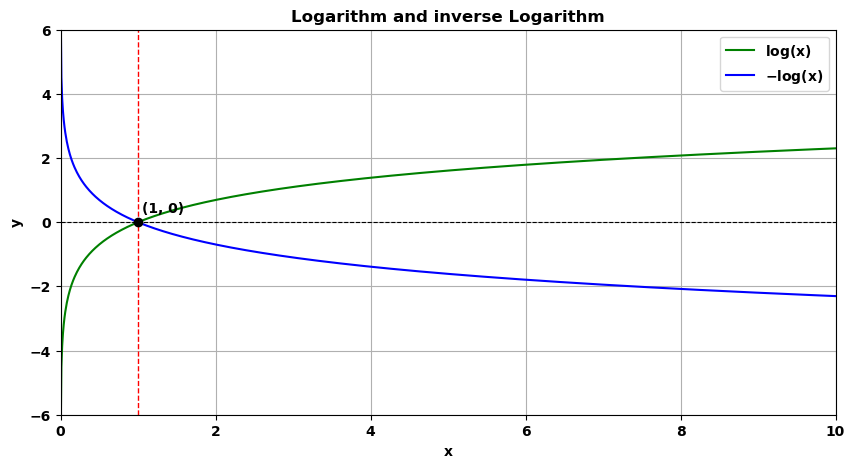

In [ ]:
x = np.linspace(0.001, 10, 1000)

# Compute log(x) and -log(x)
log_x = np.log(x)
neg_log_x = -np.log(x)

# Plot both functions
plt.figure(figsize=(10, 5))
plt.plot(x, log_x, label=r'$\log(x)$', color='green')
plt.plot(x, neg_log_x, label=r'$-\log(x)$', color='blue')

# Mark the intersection point at x = 1
plt.axvline(1, color='red', linestyle='--', linewidth=1)
plt.scatter([1], [0], color='black', zorder=5)
plt.text(1.05, 0.3, '(1, 0)', color='black')

plt.title("Logarithm and inverse Logarithm")
plt.xlabel("x")
plt.ylabel("y")
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.grid(True)
plt.legend()
plt.xlim(0, 10)
plt.ylim(-6, 6)
plt.show()

 - so, for $y=1$ we have $-\log(f_{w,b}({x}^{(i)}))$, which looks like this:

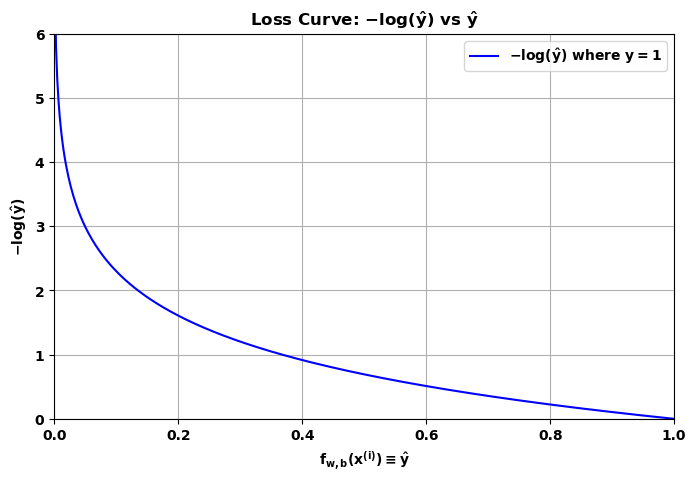

In [ ]:
f_wb = np.linspace(0.001, 0.999, 500)
loss = -np.log(f_wb)

plt.figure(figsize=(8, 5))
plt.plot(f_wb, loss, color='blue', label=r'$-\log(\hat{y})$ where $y=1$')
plt.title(r'Loss Curve: $-\log(\hat{y})$ vs $\hat{y}$')
plt.xlabel(r'$f_{w,b}(x^{(i)}) \equiv \hat{y}$')
plt.ylabel(r'$-\log(\hat{y})$')
plt.grid(True)
plt.legend()
plt.ylim(0, 6)
plt.xlim(0, 1)
plt.show()

 - and, for $y=0$ we have $-\log(1 - f_{w,b}({x}^{(i)}))$, which looks like this:

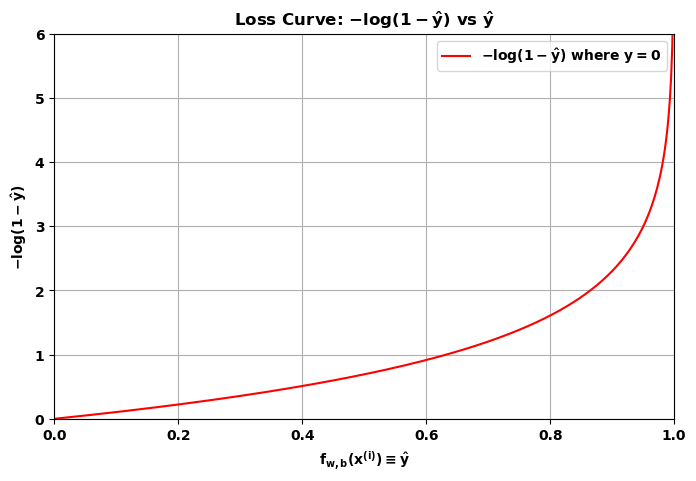

In [ ]:
loss = -np.log(1 - f_wb)

plt.figure(figsize=(8, 5))
plt.plot(f_wb, loss, color='red', label=r'$-\log(1 - \hat{y})$ where $y=0$')
plt.title(r'Loss Curve: $-\log(1 - \hat{y})$ vs $\hat{y}$')
plt.xlabel(r'$f_{w,b}(x^{(i)}) \equiv \hat{y}$')
plt.ylabel(r'$-\log(1 - \hat{y})$')
plt.grid(True)
plt.legend()
plt.ylim(0, 6)
plt.xlim(0, 1)
plt.show()

The loss function above can be rewritten to be easier to implement.
    $$loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) = \left(-y^{(i)} \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right) - \left( 1 - y^{(i)}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)$$
  
This is a rather formidable-looking equation. It is less daunting when you consider $y^{(i)}$ can have only two values, 0 and 1. One can then consider the equation in two pieces:  
when $ y^{(i)} = 0$, the left-hand term is eliminated:
$$
\begin{align*}
loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), 0) &= \left(-(0) \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right) - \left( 1 - 0\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right) \\
&= -\log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)
\end{align*}
$$
and when $ y^{(i)} = 1$, the right-hand term is eliminated:
$$
\begin{align*}
  loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), 1) &=  \left(-(1) \log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\right) - \left( 1 - 1\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)\\
  &=  -\log\left(f_{\mathbf{w},b}\left( \mathbf{x}^{(i)} \right) \right)
\end{align*}
$$

final formula for the overal cost:
$$ J(\mathbf{w},b) = \frac{1}{m} \sum_{i=0}^{m-1} \left[ loss(f_{\mathbf{w},b}(\mathbf{x}^{(i)}), y^{(i)}) \right] \tag{1}$$

- both plotted together:

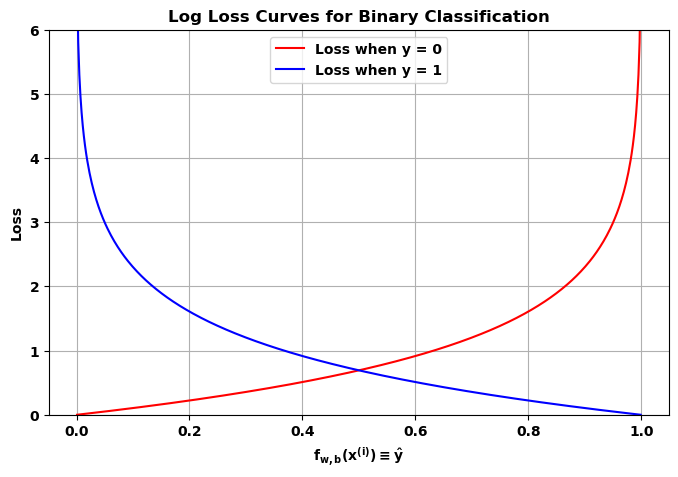

In [ ]:
def log_loss(y_true, y_pred):
    return - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

y_hat = np.linspace(0.001, 0.999, 500)

# Compute loss for both target classes: y=0 and y=1
loss_y0 = log_loss(0, y_hat)
loss_y1 = log_loss(1, y_hat)

plt.figure(figsize=(8, 5))
plt.plot(y_hat, loss_y0, label='Loss when y = 0', color='red')
plt.plot(y_hat, loss_y1, label='Loss when y = 1', color='blue')
plt.title('Log Loss Curves for Binary Classification')
plt.xlabel(r'$f_{w,b}(x^{(i)}) \equiv \hat{y}$')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.ylim(0, 6)
plt.show()

- now let`s test the influence of the cost function over our model.
- back to the example with data as:

In [ ]:
X = np.array([[0.5, 1.5], [1, 1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y = np.array([0, 0, 0, 1, 1, 1])

- the example was with $b=-3$ and $w_0 = 1, w_1 = 1$, let`s see what the cost is.

In [ ]:
w = np.array([1, 1])
b = -3

- compute the cost over all training examples:


In [ ]:
def compute_cost_logistic(X, y, w, b):
    """
    Computes cost

    Args:
      X (ndarray (m,n)): Data, m examples with n features
      y (ndarray (m,)) : target values
      w (ndarray (n,)) : model parameters  
      b (scalar)       : model parameter
      
    Returns:
      cost (scalar): cost
    """
    m = X.shape[0]
    z = X @ w + b
    f_wb = sigmoid(z)
    cost = np.mean(np.array([log_loss(y[i], f_wb[i]) for i in range(m)]))
             
    return cost

In [ ]:
print(compute_cost_logistic(X, y, w, b))

0.36686678640551745


- let`s see what happpend when $b=-4$ and $w_0 = 1, w_1 = 1$

In [ ]:
b = -4
print(compute_cost_logistic(X, y, w, b))

0.5036808636748461


- infact the cost increases and if we see the plot, we can see that the decision boundary is in the wrong place.

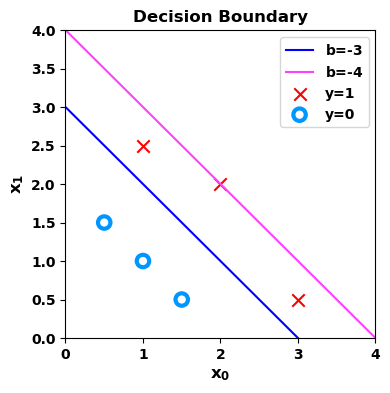

In [ ]:
x0 = np.arange(0,6)

# Plot the two decision boundaries
x1 = 3 - x0
x1_other = 4 - x0

fig,ax = plt.subplots(1, 1, figsize=(4,4))
# Plot the decision boundary
ax.plot(x0,x1, c="blue", label="$b$=-3")
ax.plot(x0,x1_other, c='#FF40FF', label="$b$=-4")
ax.axis([0, 4, 0, 4])

# Plot the data
plot_data(X,y,ax)
ax.axis([0, 4, 0, 4])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.legend(loc="upper right")
plt.title("Decision Boundary")
plt.show()

- finally lets find the best $w$ and $b$ while using gradient descent:

In [ ]:
def compute_gradient_logistic(X, y, w, b): 
    """
    Computes the gradient for logistic regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))
    dj_db = 0
    
    f_wb = X @ w + b
    error = sigmoid(f_wb) - y
    
    dj_dw = (X.T @ error) / m
    dj_db = np.sum(error) / m
        
    return dj_dw, dj_db

In [ ]:
w = np.array([0., 0.])
b = 0.
dj_dw, dj_db = compute_gradient_logistic(X, y, w, b)
print(f"dj_dw: {dj_dw}" )
print(f"dj_db: {dj_db}")

dj_dw: [-0.25       -0.16666667]
dj_db: 0.0


In [ ]:
def gradient_descent_logistic(X, y, w, b, alpha, iterations): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w (ndarray (n,)): Initial values of model parameters  
      b (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      iterations (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w_new = w  #avoid modifying global w within function
    b_new = b
    
    for i in range(iterations):
        # Calculate the gradient and update the parameters
        dj_dw, dj_db = compute_gradient_logistic(X, y, w_new, b_new)   

        # Update Parameters using w, b, alpha and gradient
        w_new -= alpha * dj_dw               
        b_new -= alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append(compute_cost_logistic(X, y, w_new, b_new))

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% np.ceil(iterations / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w_new, b_new

In [ ]:
alpha = 0.1
iterations = 10000

w, b = gradient_descent_logistic(X, y, w, b, alpha, iterations) 
print(f"\nupdated parameters: w:{w}, b:{b}")

Iteration    0: Cost 0.684610468560574   
Iteration 1000: Cost 0.1590977666870456   
Iteration 2000: Cost 0.08460064176930084   
Iteration 3000: Cost 0.05705327279402528   
Iteration 4000: Cost 0.04290759421682   
Iteration 5000: Cost 0.03433847729884565   
Iteration 6000: Cost 0.02860379802212006   
Iteration 7000: Cost 0.02450156960879306   
Iteration 8000: Cost 0.02142370332569289   
Iteration 9000: Cost 0.019030137124109094   

updated parameters: w:[5.28123029 5.07815608], b:-14.222409982019839


- plotting the result of gradient descent:

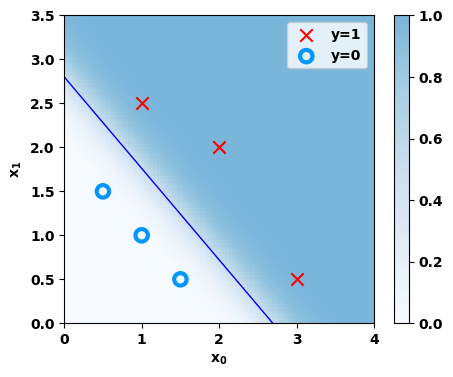

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
# plot the probability 
plot_probability(ax, w, b)

# Plot the original data
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')   
ax.axis([0, 4, 0, 3.5])
plot_data(X, y, ax)

# Plot the decision boundary
x0 = -b / w[0]
x1 = -b /w [1]
ax.plot([0,x0],[x1,0], c="blue", lw=1)
plt.show()